In [12]:
# libraries
import pandas as pd
import nltk
# from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
# import string
import spacy
import en_core_web_sm
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nlp = en_core_web_sm.load()

# python3 -m spacy download en

# download stopwords and wordnet and punctuations

# nltk.download("stopwords")
# nltk.download("wordnet")
nltk.download("punkt")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/himani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
# preprocessing
from sklearn.preprocessing import LabelEncoder

# # train_test split
from sklearn.model_selection import StratifiedKFold

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support

In [127]:
## read raw file

raw_file = pd.read_csv("LabelledData (1).txt", sep = ",,,", header = None)
raw_file.columns = ['questions','labels']
raw_file.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,questions,labels
0,how did serfdom develop in and then leave russ...,unknown
1,what films featured the character popeye doyle ?,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of .com ?,what


In [129]:
raw_file['labels'].value_counts()

 what           607
 who            401
 unknown        272
 affirmation    104
 when            96
  what            2
  who             1
Name: labels, dtype: int64

In [132]:
## remove trailing or leading spaces

raw_file['labels'] = raw_file['labels'].apply(lambda x: x.strip())
raw_file['labels'].value_counts()

what           609
who            402
unknown        272
affirmation    104
when            96
Name: labels, dtype: int64

Text(0.5,1,'Distribution of label class in train set')

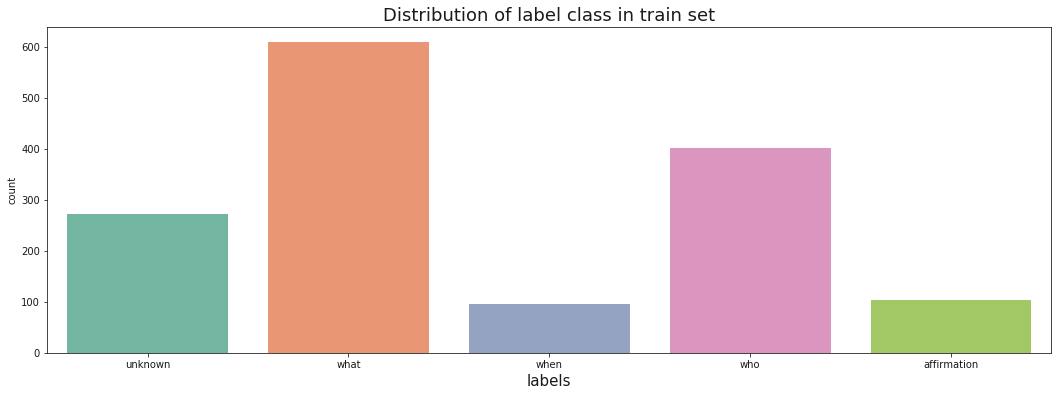

In [133]:
### distribution of levels in labels in training set

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('labels', data = raw_file,palette="Set2", ax = ax1)
ax1.set_xlabel("labels", size = 15)
plt.title("Distribution of label class in train set", size = 18)

In [134]:
## clean questions

lemma = WordNetLemmatizer()
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = " ".join(lemma.lemmatize(item) for item in tokens)
    return cleaned_article

raw_file['clean_ques'] = raw_file['questions'].apply(clean_tokenize)
raw_file.head()

,questions,labels,clean_ques
0,how did serfdom develop in and then leave russ...,unknown,how did serfdom develop in and then leave russia
1,what films featured the character popeye doyle ?,what,what film featured the character popeye doyle
2,how can i find a list of celebrities ' real na...,unknown,how can i find a list of celebrity real name
3,what fowl grabs the spotlight after the chines...,what,what fowl grab the spotlight after the chinese...
4,what is the full form of .com ?,what,what is the full form of com


### Create features from questions
- WH-word
- WH word POS
- pos of word next to WH word
- Root POS: The part of speech of the word at the root of the dependency parse tree.

In [37]:
raw_file['clean_ques'][0]

'how did serfdom develop in and then leave russia'

In [41]:
nlp = en_core_web_sm.load()

In [59]:
x = nlp(raw_file['clean_ques'][1])

In [60]:
list(x.sents)

[what film featured the character popeye doyle]

In [61]:
tags = {w.pos: w.pos_ for w in x}
tags

{83: 'ADJ', 89: 'DET', 91: 'NOUN', 99: 'VERB'}

In [62]:
for word in list(x.sents)[0]:
    print(word, word.pos_)

what ADJ
film NOUN
featured VERB
the DET
character NOUN
popeye NOUN
doyle NOUN


In [135]:
pos_list = []
def pos_question(row):
    
    # get linguistic annotations of question
    en_row = nlp(u''+ row)
    sent_list = list(en_row.sents)
    wh_bi_gram = []
    root_token = ""
    wh_pos = ""
    wh_nbor_pos = ""
    wh_word = ""
    
    for token in sent_list[0]:
        if token.tag_ == "WDT" or token.tag_ == "WP" or token.tag_ == "WP$" or token.tag_ == "WRB":
            wh_pos = token.tag_
            wh_word = token.text
            wh_bi_gram.append(token.text)
            try:
                wh_bi_gram.append(str(en_row[token.i + 1]))
                wh_nbor_pos = en_row[token.i + 1].tag_
            except IndexError:
                wh_bi_gram.append(str(en_row[token.i]))
                wh_nbor_pos = en_row[token.i].tag_
        if token.dep_ == "ROOT":
            root_token = token.tag_
    pos_list.append({'wh_pos':wh_pos, 'wh_word': wh_word, 'wh_bi_gram':wh_bi_gram,
                         'wh_nbor_pos':wh_nbor_pos, 'root_token':root_token})

#apply function
raw_file['clean_ques'].apply(pos_question)

#convert list to dataframe
pos_df = pd.DataFrame(pos_list)
pos_df.head()

,root_token,wh_bi_gram,wh_nbor_pos,wh_pos,wh_word
0,VB,"[how, did]",VBD,WRB,how
1,VBD,"[what, film]",NN,WDT,what
2,VB,"[how, can]",MD,WRB,how
3,VBP,"[what, fowl]",NN,WDT,what
4,VBZ,"[what, is]",VBZ,WP,what
5,VBD,"[what, contemptible]",JJ,WP,what
6,VBD,"[what, team]",NN,WDT,what
7,VBZ,"[what, is]",VBZ,WP,what
8,VBP,"[what, are]",VBP,WP,what
9,VB,[],,,


### Prepare data for model

In [143]:
## concatnate labels column to pos_df

final_data = pd.concat([pos_df,raw_file[['labels']]], axis =1)

### one hot encoding of categorical variables and label encoding of labels

cols = ['root_token','wh_nbor_pos','wh_pos','wh_word']
X = pd.get_dummies(final_data[cols])
X = X.values
le = LabelEncoder()
y = le.fit_transform(final_data['labels'])


In [137]:
final_data['labels'].value_counts()

what           609
who            402
unknown        272
affirmation    104
when            96
Name: labels, dtype: int64

In [154]:
def run_models(model,X_train, X_test,y_train):
    model_inst = model
    model_inst.fit(X_train,y_train)
    y_pred = model_inst.predict(X_test)
    return y_pred
    
## evaluation metrics

def get_performance_metrics(y_test,y_pred):
    # Accuracy
    global model_accuracy
    model_accuracy = accuracy_score(y_test,y_pred)
    print("Accuracy is ", model_accuracy)

    # precision, recall, f1 score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test,y_pred)
    print('Precision for each class is ', model_precision)
    print('Recall/sensitivity for each class is ', model_recall)
    print('F1 Score for each class is ', model_f1)

    # confusion matrix
    model_confusion_matrix = confusion_matrix(y_test,y_pred)
    print('confusion matrix is :-->')
    print(model_confusion_matrix)

In [155]:
## run models using stratified sampling

skf = StratifiedKFold(n_splits=3, random_state = 5678)

avg_acc_nb = []
avg_acc_log = []
avg_acc_dec = []
avg_acc_ran =[]
abg_acc_svm = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Naive bayes classifer
    y_pred = run_models(MultinomialNB(),X_train, X_test,y_train)
    print("Performance metrics for Naive bayes model in {0}- Fold: \n".format(i))
    get_performance_metrics(y_test,y_pred)
    print("---------------------------------------------------------\n")
    avg_acc_nb.append(model_accuracy)
    
    # Logistic classifier
    y_pred = run_models(LogisticRegression(multi_class='multinomial',solver = 'lbfgs',
                                           random_state = 5678),X_train, X_test,y_train)
    print("Performance metrics for Logistic Regression in {0}- Fold: \n".format(i))
    get_performance_metrics(y_test,y_pred)
    print("---------------------------------------------------------\n")
    avg_acc_log.append(model_accuracy)
    
    # Decision Tree classifier
    y_pred = run_models(DecisionTreeClassifier(random_state = 5678),X_train, X_test,y_train)
    print("Performance metrics for Decision Tree model in {0}- Fold: \n".format(i))
    get_performance_metrics(y_test,y_pred)
    print("---------------------------------------------------------\n")
    avg_acc_dec.append(model_accuracy)
    
    # random Forest Classifier
    y_pred = run_models(RandomForestClassifier(random_state = 5678),X_train, X_test,y_train)
    print("Performance metrics for Random Forest model in {0}- Fold: \n".format(i))
    get_performance_metrics(y_test,y_pred)
    print("---------------------------------------------------------\n")
    avg_acc_ran.append(model_accuracy)

    # Support vector machines
    y_pred = run_models(SVC(random_state = 5678),X_train, X_test,y_train)
    print("Performance metrics for SVC model in {0}- Fold: \n".format(i))
    get_performance_metrics(y_test,y_pred)
    print("---------------------------------------------------------\n")
    abg_acc_svm.append(model_accuracy)
    

Performance metrics for Naive bayes model in 0- Fold: 

Accuracy is  0.911111111111
Precision for each class is  [ 0.86486486  0.91025641  0.88687783  0.75        1.        ]
Recall/sensitivity for each class is  [ 0.91428571  0.78021978  0.96551724  0.65625     0.97761194]
F1 Score for each class is  [ 0.88888889  0.84023669  0.9245283   0.7         0.98867925]
confusion matrix is :-->
[[ 32   3   0   0   0]
 [  5  71  12   3   0]
 [  0   3 196   4   0]
 [  0   0  11  21   0]
 [  0   1   2   0 131]]
---------------------------------------------------------

Performance metrics for Logistic Regression in 0- Fold: 

Accuracy is  0.931313131313
Precision for each class is  [ 0.86486486  0.93975904  0.92093023  0.75        1.        ]
Recall/sensitivity for each class is  [ 0.91428571  0.85714286  0.97536946  0.65625     0.98507463]
F1 Score for each class is  [ 0.88888889  0.89655172  0.94736842  0.7         0.9924812 ]
confusion matrix is :-->
[[ 32   3   0   0   0]
 [  5  78   5   3   

In [156]:
print("Average accuracy in Naive Bayes:", sum(avg_acc_nb)/len(avg_acc_nb))
print("Average accuracy in Logistic:", sum(avg_acc_log)/len(avg_acc_log))
print("Average accuracy in Decision:", sum(avg_acc_dec)/len(avg_acc_dec))
print("Average accuracy in Random Forest:", sum(avg_acc_ran)/len(avg_acc_ran))
print("Average accuracy in SVC:", sum(abg_acc_svm)/len(abg_acc_svm))

Average accuracy in Naive Bayes: 0.917713989114
Average accuracy in Logistic: 0.936596526455
Average accuracy in Decision: 0.931874526195
Average accuracy in Random Forest: 0.938616728475
Average accuracy in SVC: 0.930535920394
